In [1]:
from pathlib import Path
import pandas as pd

BASE = Path.cwd()
# если ноутбук запускают из корня репо, и если из homeworks/HW05
candidates = [
    BASE / "S05-hw-dataset.csv",
    BASE / "homeworks" / "HW05" / "S05-hw-dataset.csv",
]
data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("Не найден S05-hw-dataset.csv ни в текущей папке, ни в homeworks/HW05")
df = pd.read_csv(data_path)
fig_dir = BASE / "figures"
if not fig_dir.exists():
    fig_dir = BASE / "homeworks" / "HW05" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay,
)


In [3]:
df = pd.read_csv("S05-hw-dataset.csv")
df.head()


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [4]:
df.info()
df.describe()
df["default"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

# 3000 строк, 17 столбцов.
# Все признаки числовые, пропусков нет (везде 3000 non-null).
# Таргет: класс 1 ≈ 41%, класс 0 ≈ 59% – умеренно несбалансированная задача, accuracy ещё имеет смысл, но ROC-AUC тоже важен.

In [5]:
target_col = "default"
id_col = "client_id"
X = df.drop(columns=[target_col, id_col])
y = df[target_col]
X.shape, y.shape

((3000, 15), (3000,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

((2400, 15), (600, 15))

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)
print(f"Dummy acc.: {acc_dummy:.3f}")
print(f"Dummy ROC-AUC: {roc_auc_dummy:.3f}")

Dummy acc.: 0.590
Dummy ROC-AUC: 0.500


# в качестве бейзлайна использовался DummyClassifier со стратегией most_frequent.
# модель всегда предсказывает самый частый класс в обучающей выборке, не смотрит на признаки
# на тестовой выборке она даёт accuracy около 0.59, что по сути равно доле нулевого класса, и ROC-AUC около 0.50, то есть работает как случайное угадывание.
# ожидаемо и подтверждает, что без использования признаков модель ничего полезного из себя не представляет.
# дальше логистическая регрессия будет сравниваться именно с этим бейзлайном, чтобы понять, есть ли реальный прирост качества, а не просто формальная модель.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000)),
])
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0],
}
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",  # отмимизэйшн по roc_auc
    n_jobs=-1,
)
grid.fit(X_train, y_train)
        
print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_model = grid.best_estimator_

Best params: {'logreg__C': 10.0}
Best CV ROC-AUC: 0.8606590016322577


In [12]:
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("LogisticRegression (best C)")
print(f"Accuracy: {acc_lr:.3f}")
print(f"ROC-AUC : {roc_auc_lr:.3f}")

LogisticRegression (best C)
Accuracy: 0.800
ROC-AUC : 0.876


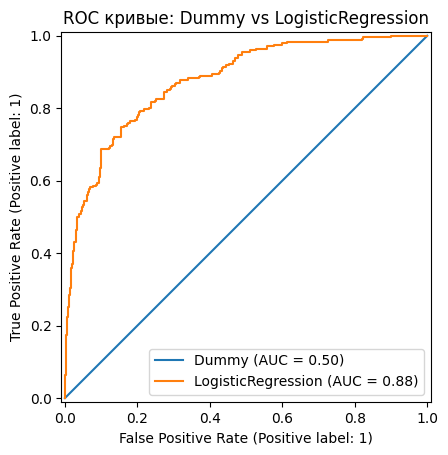

In [13]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
    dummy, X_test, y_test, ax=ax, name="Dummy"
)
RocCurveDisplay.from_estimator(
    best_model, X_test, y_test, ax=ax, name="LogisticRegression"
)

ax.set_title("ROC кривые: Dummy vs LogisticRegression")
from pathlib import Path
Path("figures").mkdir(parents=True, exist_ok=True)
plt.savefig("figures/roc_curve.png", bbox_inches="tight")
plt.show()

In [14]:
results = pd.DataFrame({
    "model": ["Dummy(most_frequent)", "LogisticRegression(best C)"],
    "accuracy": [acc_dummy, acc_lr],
    "roc_auc":  [roc_auc_dummy, roc_auc_lr],
}).set_index("model")

results

,accuracy,roc_auc
model,,
Dummy(most_frequent),0.59,0.500000
LogisticRegression(best C),0.80,0.875637


# Accuracy и ROC-AUC у Dummy и у логистической регрессии: есть (0.590/0.500 и 0.800/0.876).
# Насколько выросли метрики: есть (примерно +0.210 accuracy, +0.376 ROC-AUC).
# Какой C лучший и что с качеством при разных C: есть (лучший C=10.0, best CV ROC-AUC=0.861)
# при росте C качество в целом улучшалось и маленький C хуже из-за сильной регуляризации.
# следует выбрать логистическую регрессию, потому что существенно лучше бейзлайна по метрикам и по ранжированию.